## DDIM with similar noise

In this notebook we will perform some experiments with Denoising Diffusion Implicit Models (DDIM). Unlike Denoising Diffusion Probabilistic Models (DDPM) DDIMs work deterministic, i.e. from one specific full noise picture it will always generate the same clear picture. Using a deterministic backwards process is essential here. If we used a probabilistic model, there would be a little noise added back into the picture after every backwards step, which would make the results differ heavily regardless of the starting point.

We will do 2 Experimernts:

1. Experiment: Change a small patch in the full noise picture and generate two clear images from it.
2. Experiment: Change the full noise images in a way that the mathematical distance between the two full noise images used as a starting point is very small.

Each experiments will demonstrate different things:

1. Experiment: Changing a small patch in the full noise picture will not only change that exact patch in the clear picture, but the whole picture. This shows that diffusion models captures dependecies between pixels by capturing the probablity distribtutions in the training dataset.
2. Experiment: Changing the noise only a little only changes the resulting clear image a little, which ist expected using a DDIM. Feel free to play around with the Variable noise_scaling_factor and set it to values between 0 and 1.



## Setup

In [2]:
from functions import *

In [3]:
import torch
import diffusers
from PIL import Image
from tqdm import tqdm
import os

c:\Users\Tom\conda_environments\Diffusion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# setup
model_id = "google/ddpm-bedroom-256" # "google/ddpm-celebahq-256"
model = diffusers.UNet2DModel.from_pretrained(model_id)
ddpm_scheduler = diffusers.DDPMScheduler.from_pretrained(model_id)
ddpm_scheduler.set_timesteps(50)

An error occurred while trying to fetch google/ddpm-bedroom-256: google/ddpm-bedroom-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [5]:
# input prepraration
image_size = model.config.sample_size # get image size
noise = torch.randn((1, 3, image_size, image_size)) # sample random noise

## 1. Experiment

In [6]:
# setup
ddim_scheduler = diffusers.DDIMScheduler.from_pretrained(model_id)
ddim_scheduler.set_timesteps(50)

,,
,Euclidean distance: 122.08182525634766,

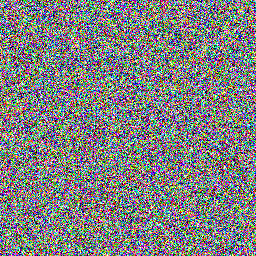
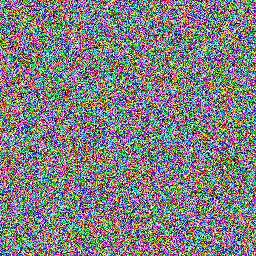
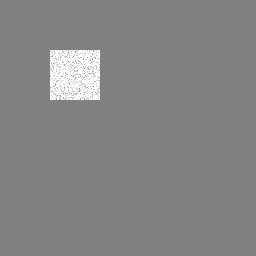

In [ ]:
patchsize = 50 

# prepare input
noise = torch.randn((1, 3, image_size, image_size)) # sample random noise
noises = [noise.clone() for _ in range(2)] # duplicate noise
noises[1][:,:,50:100,50:100] = torch.randn((1, 3, 50, 50)) # change a small patch in one of the full noise pictures
#show_images(*noises, torch.abs(noises[0]-noises[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))
euclidean = torch.norm((noises[0]-noises[1])).item() # calculate euclidean distance
show_table([[tensor_as_html(noises[0]), tensor_as_html(noises[1]), tensor_as_html(torch.abs(noises[0]-noises[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))], ["", f"Euclidean distance: {euclidean}", ""]])

""

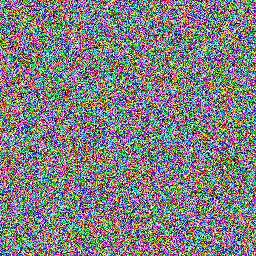

In [21]:
# display the images alternately
from time import sleep
for i in range(10):
    show_images(noises[i % 2])
    sleep(0.5)

In [22]:
# output generation
images = list()
for current in noises:
    for t in tqdm(ddim_scheduler.timesteps):
        with torch.no_grad():
            predicted_noise = model(current, t).sample
            current = ddim_scheduler.step(predicted_noise, t, current).prev_sample
    images.append(current)

100%|██████████| 50/50 [01:51<00:00,  2.22s/it]


,,
,Euclidean distance: 59.67145919799805,

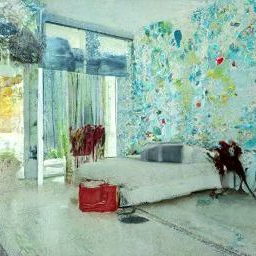
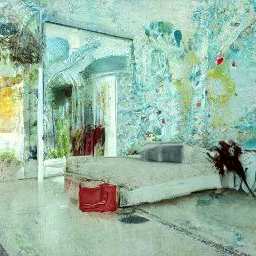
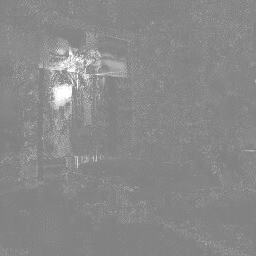

In [23]:
# show output
euclidean = torch.norm((images[0]-images[1])).item() # calculate euclidean distance
show_table([[tensor_as_html(images[0]), tensor_as_html(images[1]), tensor_as_html(torch.abs(images[0]-images[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))], ["", f"Euclidean distance: {euclidean}", ""]])
#show_images(*images, torch.abs(images[0]-images[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))

In [24]:
# save input and output
for i in range(len(noises)):
    tensor_as_image(noises[i]).save(f"../output/similar_ddim_noise_{i}.png")
    tensor_as_image(images[i]).save(f"../output/similar_ddim_image_{i}.png")

## 2. Experiment

,,
,Euclidean distance: 44.55112075805664,

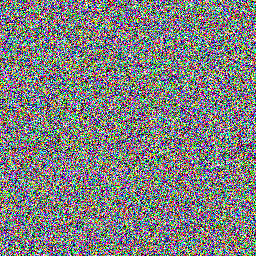
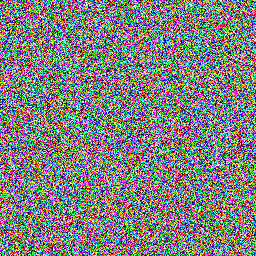
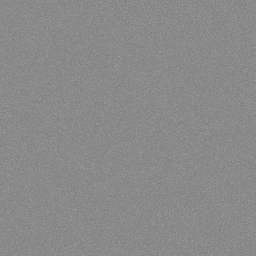

In [ ]:
# prepare input
noise_scaling_factor = 0.1 # this is used to decide how much the two nosies differ, FEEL FREE TO ADJUST

noise = torch.randn((1, 3, image_size, image_size)) # sample random noise
noises = [noise.clone() for _ in range(2)] # duplicate noise
noises[1] = ((1-noise_scaling_factor**2)**0.5) * noises[1] + noise_scaling_factor * torch.randn((1, 3, image_size, image_size)) # change one of the full noise pictures by adding newly generated noise scaled down heavily
euclidean = torch.norm((noises[0]-noises[1])).item() # calculate euclidean distance
show_table([[tensor_as_html(noises[0]), tensor_as_html(noises[1]), tensor_as_html(torch.abs(noises[0]-noises[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))], ["", f"Euclidean distance: {euclidean}", ""]])
#show_images(*noises, torch.abs(noises[0]-noises[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))


In [27]:
# output generation
images = list()
for current in noises:
    for t in tqdm(ddim_scheduler.timesteps):
        with torch.no_grad():
            predicted_noise = model(current, t).sample
            current = ddim_scheduler.step(predicted_noise, t, current).prev_sample
    images.append(current)

100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


,,
,Euclidean distance: 49.10825729370117,

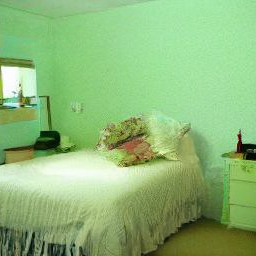
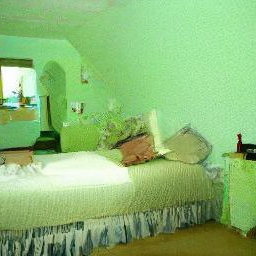
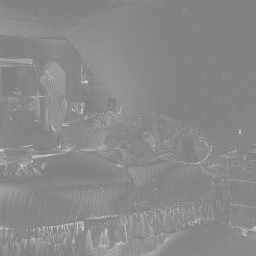

In [28]:
# show output
euclidean = torch.norm((images[0]-images[1])).item() # calculate euclidean distance
show_table([[tensor_as_html(images[0]), tensor_as_html(images[1]), tensor_as_html(torch.abs(images[0]-images[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))], ["", f"Euclidean distance: {euclidean}", ""]])
#show_images(*images, torch.abs(images[0]-images[1]).mean(dim=1,keepdim=True).repeat(1,3,1,1))